In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

import matplotlib.pyplot as plt
import time
import numpy as np
import random
import warnings
import os
from tqdm import tqdm

import pandas as pd

from zipfile import ZipFile
from urllib.request import urlretrieve


%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
#set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seed(42)

In [3]:
#download and extract dataset
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    #download zip file
    urlretrieve(url, save_path)

    try:
        #extract
        with ZipFile(save_path) as z:
            #extract zipfile in same directory
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1"

dataset_path = os.path.join(os.getcwd(), "10_Monkey_Species.zip")

#download if asset ZIP doesn't exists
if not os.path.exists(dataset_path):
    download_and_unzip(URL, dataset_path)
else:
    print("Download already...")

In [4]:
#set dataset and training config parameters

@dataclass(frozen=True)
class TrainingConfig:
    
    batch_size: int = 32
    num_epochs: int = 100
    learning_rate: float = 1e-4

    log_interval: int = 1
    test_interval: int = 1
    data_root: int = "./"
    num_workers: int = 5
    device: str = "cuda"

train_config = TrainingConfig()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Devics:", DEVICE)

Devics: cuda


In [14]:
#process monkey file
train_root = os.path.join("10_Monkey_Species", "training", "training")
val_root = os.path.join("10_Monkey_Species", "validation", "validation")

In [15]:
#make pandas dataframe to arrange the data

df = pd.read_csv(os.path.join("10_Monkey_Species", "monkey_labels.txt"), sep=",", header=None)
df.columns = ["Labels", "Latin Name", "Common Name", "Train Images", "Validation Images"]
df["Latin Name"] = df["Latin Name"].str.replace("\t", " ")
df[1:]
                                                

,Labels,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [ ]:
#preprocessing
#normalise image data to range [0,1] with meaan and std od datasets



img_size = (224, 224)

preprocess = transforms.Compose(
    [
        transforms.Resize(img_size, antialias=True),
        transforms.ToTensor()
    ]
)

In [ ]:
#find mean and std of dataset
def get_mean_std(train_loader, img_size=(224,224), num_workers=2):

    batch_mean = torch.zeros(3)
    batch_mean_sqrd  = torch.zeros(3)

    for batch_data, _ in train_loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3)) #E[batch_i] #dim=1 is channel dim
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3)) #E[batch_i**2]

    mean = batch_mean / len(train_loader)

    var = (batch_mean_sqrd / len(train_loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

train_data_mean_calc = datasets.ImageFolder(root=train_root, transform=preprocess)
train_loader_mean_calc = DataLoader(train_data_mean_calc, shuffle = True, batch_size = train_config.batch_size, num_workers = train_config.num_workers)
mean, std = get_mean_std(train_loader_mean_calc)

print("Mean of Dataset: ", mean)
print("Std of Dataset: ", std)

mean: tensor([0.4369, 0.4331, 0.3289]), std: tensor([0.2461, 0.2416, 0.2450])
Mean of Dataset:  tensor([0.4369, 0.4331, 0.3289])
Std of Dataset:  tensor([0.2461, 0.2416, 0.2450])


In [29]:
mean = [0.4368, 0.4336, 0.3294]
std = [0.2457, 0.2413, 0.2447]

common_transforms = transforms.Compose(
    [
        preprocess,
        transforms.Normalize(mean=mean, std=std)
    ]
)

train_transforms = transforms.Compose(
    [
        preprocess,
        transforms.RandomHorizontalFlip(),
        transforms.RandomErasing(p=0.4),
        transforms.RandomApply(
            [
                transforms.RandomAffine(degrees=(30,70), translate=(0.1, 0.3), scale=(0.5, 0.75))
            ], p=0.1),
        transforms.Normalize(mean=mean, std=std)
    ]
)

In [20]:
#dataloader preparation
#apply augmentation to train data
train_data = datasets.ImageFolder(root = train_root, transform = train_transforms)

#validation set
val_data = datasets.ImageFolder(root = val_root, transform = common_transforms)
train_data.classes


['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [21]:
train_data.class_to_idx


{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [22]:
len(train_data)

1097

In [30]:
train_loader = DataLoader(
    train_data,
    shuffle = True,
    batch_size = train_config.batch_size,
    num_workers = train_config.num_workers
)

val_loader = DataLoader(
    val_data,
    shuffle = False,
    batch_size = train_config.batch_size,
    num_workers = train_config.num_workers
)

In [31]:
len(next(iter(train_loader)))

2

In [32]:
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

torch.Size([32, 3, 224, 224])


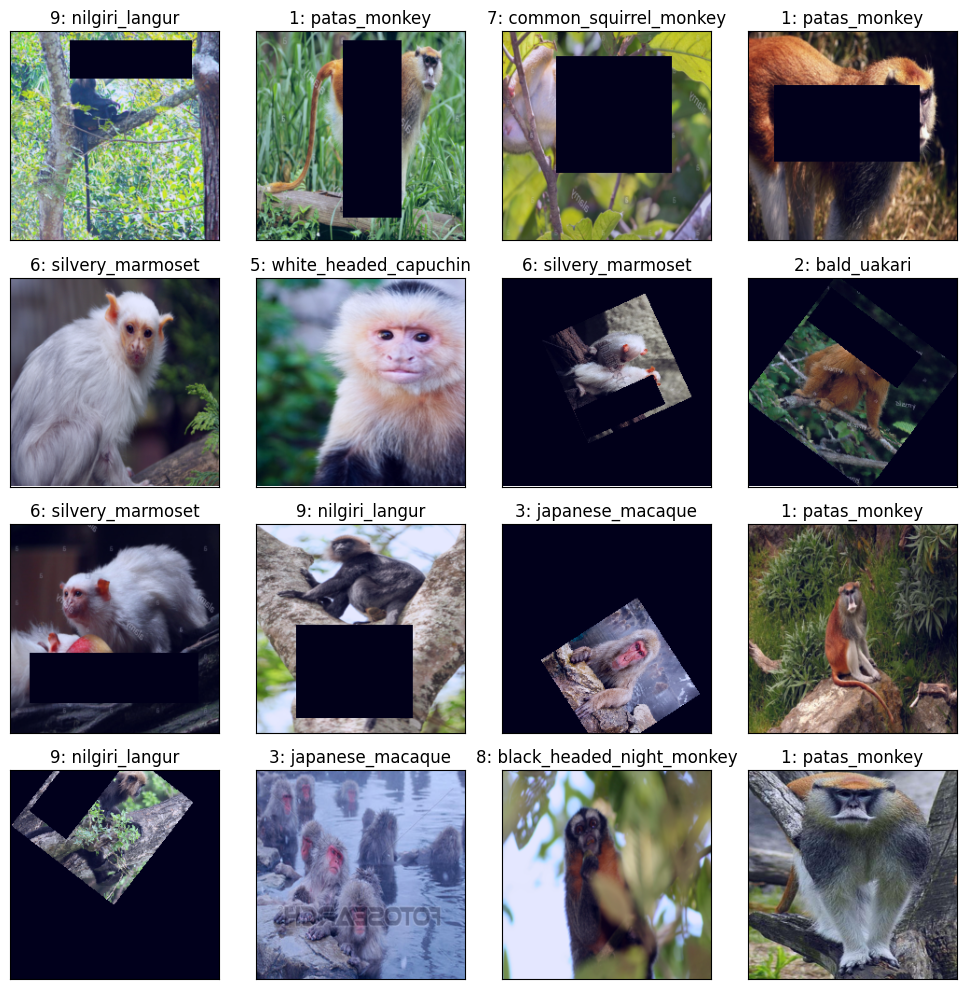

In [ ]:
#display image
def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10,10))

    #iterate over first batch
    images, labels = next(iter(dataloader))
    print(images.shape)

    num_rows = 4
    num_cols = int(np.ceil((num_images / num_rows)))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]

        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks = [], yticks = [])

        image = image.permute(1,2,0) #matplotlib format

        #normalize image
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray") #remove batch dimension
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images = 16)